In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Add parent directory to path to import config
sys.path.append(str(Path().resolve().parent))
from config import DATA_DIR, RF_SELECTED_DATA_PATH, REDUCED_CLEANED_DATA_PATH, UNION_CLEANED_DATA_PATH

data_folder = str(DATA_DIR) + "\\"

In [26]:
# Load the cleaned data for feature selection
from config import CLEANED_DATA_PATH
df = pd.read_csv(CLEANED_DATA_PATH)

# Prepare features and target
X = df.drop(columns=['target'])
y = df['target']

print(f"Data shape: {df.shape}")
print(f"Features: {X.columns.tolist()}")
print(f"Target distribution:\n{y.value_counts()}")

Data shape: (720, 25)
Features: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'restecg_0.5682451253481894', 'restecg_1.0', 'restecg_2.0', 'slope_1.7017543859649122', 'slope_2.0', 'slope_3.0', 'thal_4.985', 'thal_6.0', 'thal_7.0', 'ca_0.6807817589576547', 'ca_1.0', 'ca_2.0', 'ca_3.0']
Target distribution:
target
0    360
1    360
Name: count, dtype: int64


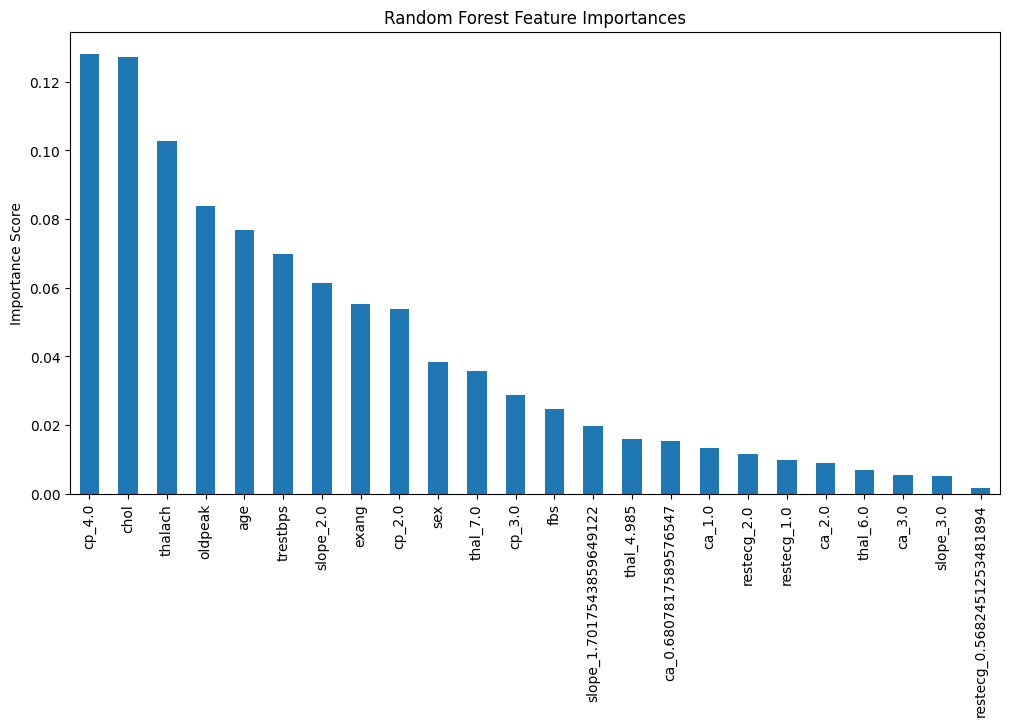

In [27]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Fit a random forest
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get importance scores
importances = model.feature_importances_
feature_names = X.columns

# Plot
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12, 6), title="Random Forest Feature Importances")
plt.ylabel("Importance Score")
plt.show()


In [28]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Base model for RFE
estimator = LogisticRegression(max_iter=1000)
selector = RFE(estimator, n_features_to_select=10)
selector = selector.fit(X, y)

# Selected features
selected_features = X.columns[selector.support_]
print("Selected Features by RFE:", selected_features.tolist())


Selected Features by RFE: ['sex', 'exang', 'cp_4.0', 'restecg_0.5682451253481894', 'slope_2.0', 'thal_7.0', 'ca_0.6807817589576547', 'ca_1.0', 'ca_2.0', 'ca_3.0']


In [29]:
from sklearn.feature_selection import SelectKBest, chi2

X_chi2 = X.copy()
X_chi2[X_chi2 < 0] = 0

chi2_selector = SelectKBest(score_func=chi2, k=10)
chi2_selector.fit(X_chi2, y)

chi2_features = X.columns[chi2_selector.get_support()]
print("Selected Features by Chi-Square Test:", chi2_features.tolist())


Selected Features by Chi-Square Test: ['age', 'thalach', 'exang', 'oldpeak', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'slope_1.7017543859649122', 'slope_2.0', 'thal_7.0']


In [30]:
# 1. Random Forest - top N features
rf_top_n = feat_imp.head(15).index.tolist()

# 2. RFE selected features
rfe_selected = selected_features.tolist()

# 3. Chi-Square selected features
chi2_selected = chi2_features.tolist()

# Final overlap
final_features = list(set(rf_top_n) & set(rfe_selected) & set(chi2_selected))
print("Overlapping Selected Features:", final_features)

# Save reduced dataset using config path
X_reduced = X[final_features]
X_reduced['target'] = y
X_reduced.to_csv(REDUCED_CLEANED_DATA_PATH, index=False)
print(f"✅ Saved reduced data to {REDUCED_CLEANED_DATA_PATH}")

# Save union dataset using config path
union_features = list(set(rf_top_n).union(set(rfe_selected)))
X_union = X[union_features]
X_union['target'] = y
X_union.to_csv(UNION_CLEANED_DATA_PATH, index=False)
print(f"✅ Saved union data to {UNION_CLEANED_DATA_PATH}")

Overlapping Selected Features: ['cp_4.0', 'exang', 'slope_2.0', 'thal_7.0']
✅ Saved reduced data to G:\Courses\Sprints_ML\Project\data\reduced_cleaned_data.csv
✅ Saved union data to G:\Courses\Sprints_ML\Project\data\union_cleaned_data.csv


C:\Users\nmohm\AppData\Local\Temp\ipykernel_32572\3884082341.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reduced['target'] = y
C:\Users\nmohm\AppData\Local\Temp\ipykernel_32572\3884082341.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_union['target'] = y


In [31]:
import pandas as pd

# Full feature dataset (without PCA)
df_full = pd.read_csv(data_folder + "cleaned_data.csv")
X_full = df_full.drop(columns=["target"])

# Reduced feature dataset
df_reduced = pd.read_csv(data_folder + "reduced_cleaned_data.csv")
X_reduced = df_reduced.drop(columns=["target"])


In [32]:
from sklearn.preprocessing import StandardScaler

scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_full)

scaler_reduced = StandardScaler()
X_reduced_scaled = scaler_reduced.fit_transform(X_reduced)


In [33]:
from sklearn.decomposition import PCA
import numpy as np

# Full PCA
pca_full = PCA()
pca_full.fit(X_full_scaled)
total_variance_full = np.sum(pca_full.explained_variance_)

# Reduced PCA
pca_reduced = PCA()
pca_reduced.fit(X_reduced_scaled)
total_variance_reduced = np.sum(pca_reduced.explained_variance_)

# Calculate % retained
variance_retained = total_variance_reduced / total_variance_full * 100
print(f"Variance retained by selected features: {variance_retained:.2f}%")


Variance retained by selected features: 16.67%


In [34]:
def compute_variance_retained(feature_list, X_full):
    scaler = StandardScaler()
    X_subset = X_full[feature_list]
    X_scaled = scaler.fit_transform(X_subset)

    pca = PCA()
    pca.fit(X_scaled)
    return np.sum(pca.explained_variance_)

In [35]:
# Load full feature set
df = pd.read_csv(data_folder + "cleaned_data.csv")
X_full = df.drop(columns=["target"])

# Total variance (denominator)
X_full_scaled = StandardScaler().fit_transform(X_full)
total_variance_full = np.sum(PCA().fit(X_full_scaled).explained_variance_)

# Variance per method
var_rf = compute_variance_retained(rf_top_n, X_full)
var_rfe = compute_variance_retained(rfe_selected, X_full)
var_chi2 = compute_variance_retained(chi2_selected, X_full)

# Percent variance retained
print(f"RF Top N:     {var_rf / total_variance_full * 100:.2f}%")
print(f"RFE Selected: {var_rfe / total_variance_full * 100:.2f}%")
print(f"Chi2 Top K:   {var_chi2 / total_variance_full * 100:.2f}%")

RF Top N:     62.50%
RFE Selected: 41.67%
Chi2 Top K:   41.67%


In [36]:
# Reduced dataset using RF-selected features
X_rf = X_full[rf_top_n]
X_rf['target'] = df['target']
X_rf.to_csv(RF_SELECTED_DATA_PATH, index=False)
print(f"✅ Saved RF selected data to {RF_SELECTED_DATA_PATH}")

✅ Saved RF selected data to G:\Courses\Sprints_ML\Project\data\rf_selected_data.csv


C:\Users\nmohm\AppData\Local\Temp\ipykernel_32572\2203747131.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_rf['target'] = df['target']
